In [1]:
import numpy as np
import pandas as pd

In [2]:
# Read in all data

data = pd.read_csv('201706-citibike-tripdata.csv').drop(['bikeid','usertype','birth year','gender'], axis=1)
data['starttime'] = pd.to_datetime(data['starttime'])
data['stoptime'] = pd.to_datetime(data['stoptime'])
data.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude'],
      dtype='object')

In [3]:
# Clean up station information

station = np.vstack([data[['start station id','start station name',
                           'start station latitude','start station longitude']],
                     data[['end station id','end station name',
                           'end station latitude','end station longitude']]])

station = pd.DataFrame(station, columns=['station id','station name',
                                         'station latitude','station longitude'])

station = station.drop_duplicates().sort_values('station id')
station = station[station['station name'] != 'LPI Facility'].reset_index(drop=True)
station.head()

,station id,station name,station latitude,station longitude
0,72,W 52 St & 11 Ave,40.7673,-73.9939
1,79,Franklin St & W Broadway,40.7191,-74.0067
2,82,St James Pl & Pearl St,40.7112,-74.0002
3,83,Atlantic Ave & Fort Greene Pl,40.6838,-73.9763
4,116,W 17 St & 8 Ave,40.7418,-74.0015


In [4]:
# Calculate the stock of each station

C = pd.DataFrame([])

for key in station['station id']:
    temp = data[(data['start station id'] == key) | (data['end station id'] == key)].copy()
    temp['change'] = np.where(temp['start station id'] == key, -1, 1)
    temp['changetime'] = np.where(temp['start station id'] == key, temp['starttime'], temp['stoptime'])
    temp['changetime'] = temp['changetime'].dt.floor('15min') # Down sampling into 15 minutes

    change = temp.groupby('changetime')['change'].sum().reset_index() # Calculate the total change in 15 minutes
    change['time'] = change['changetime'].dt.time # Remove the date information

    stock = change.groupby('time')['change'].mean().cumsum() + 12 # Calculate the monthly average
    
    C[key] = stock

C = C.fillna(method='ffill')

C.head()

,72,79,82,83,116,119,120,127,128,143,...,3461,3462,3463,3464,3466,3468,3469,3470,3472,3474
time,,,,,,,,,,,,,,,,,,,,,
00:00:00,12.461538,12.076923,12.714286,11.333333,12.500000,13.0,12.125000,11.705882,12.000000,12.142857,...,12.166667,12.750000,11.777778,11.833333,11.000000,NaN,11.5,NaN,NaN,NaN
00:15:00,12.961538,12.076923,12.914286,10.733333,12.394737,13.0,12.267857,11.455882,11.739130,11.809524,...,11.166667,12.125000,11.777778,10.833333,10.333333,NaN,12.5,NaN,NaN,NaN
00:30:00,13.711538,12.167832,12.164286,10.108333,12.966165,13.0,13.267857,11.691176,11.405797,12.309524,...,10.166667,11.852273,12.316239,11.633333,11.047619,NaN,12.5,NaN,NaN,NaN
00:45:00,13.611538,12.042832,13.164286,10.251190,12.251880,14.0,14.267857,11.441176,10.961353,12.934524,...,10.166667,12.185606,11.744811,11.300000,11.047619,NaN,12.5,NaN,NaN,NaN
01:00:00,13.736538,11.709499,13.164286,10.251190,11.651880,14.0,14.553571,10.941176,10.807507,13.267857,...,10.166667,11.852273,11.494811,11.700000,10.547619,NaN,12.5,NaN,NaN,NaN


In [5]:
# Set the filter

P = ((C < 5) | (C > 20)).astype('float')
P.head()

,72,79,82,83,116,119,120,127,128,143,...,3461,3462,3463,3464,3466,3468,3469,3470,3472,3474
time,,,,,,,,,,,,,,,,,,,,,
00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


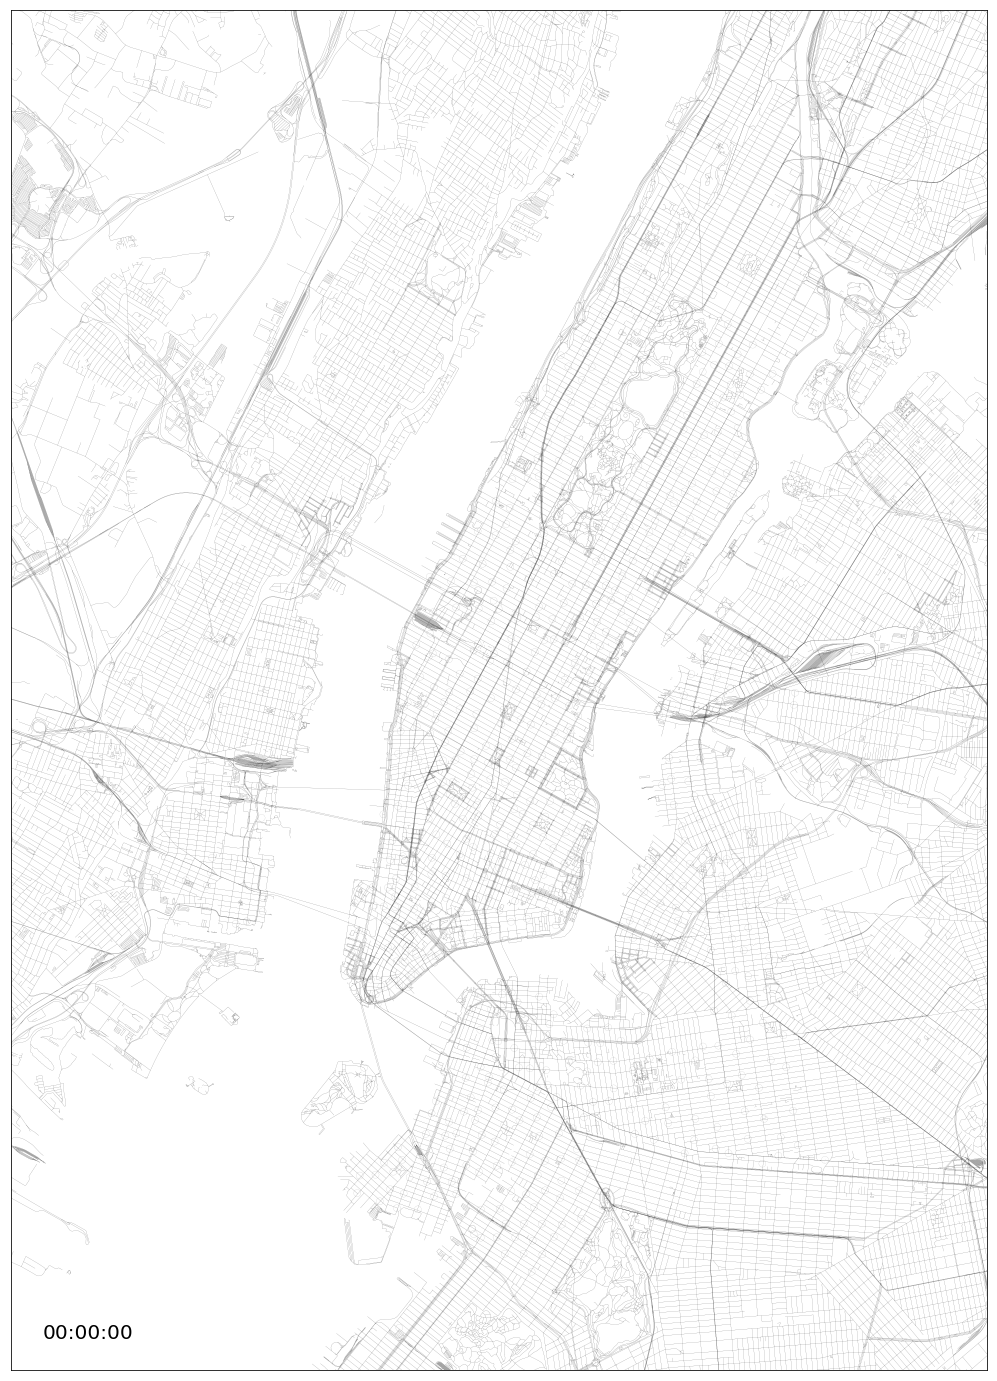

In [8]:
from mpl_toolkits.basemap import Basemap

fig = plt.figure(figsize=(14,19.3))
ax = fig.add_subplot(111)

# Read in New York map
bmap = Basemap(projection='merc', lat_ts=40.65,
               llcrnrlat=40.65, urcrnrlat=40.84,
               llcrnrlon=-74.08, urcrnrlon=-73.90,
               resolution=None, ax=ax)

shp_info = bmap.readshapefile('C:/Users/Lin Yuming/Downloads/new-york_new-york.imposm-shapefiles/new-york_new-york_osm_roads',
                              'shp', drawbounds=True, linewidth=0.1)

# Set the color threshold
norm = mpl.colors.Normalize(vmin=-50, vmax=70)
sm = mpl.cm.ScalarMappable(cmap='bwr_r', norm=norm) # Red for insufficient, blue for excess

color = sm.to_rgba(C.iloc[0,:])
color[:, -1] = P.iloc[0,:]

x, y = bmap(station['station longitude'].values, 
            station['station latitude'].values)
scat = bmap.scatter(x, y, s=50, facecolors=color, edgecolors='k', lw=0.05)
text = ax.text(500, 500, None, size=20)

fig.tight_layout(pad=1.03)

# Set Animation
def update(i):
    color = sm.to_rgba(C.iloc[i,:])
    color[:, -1] = P.iloc[i,:]
    
    scat.set_facecolors(color)
    text.set_text(C.index[i])

anim = animation.FuncAnimation(fig, update, frames=C.shape[0], interval=200)
anim.save('flow.mp4')